In [1]:
import sys
import os, shutil
import gc
import torch
import copy
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import open3d
import transforms3d
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
import glob
from torch.utils.data import Dataset
from open3d import read_point_cloud
from tqdm import tqdm_notebook
import pandas as pd
from multiprocessing import Pool, cpu_count

In [2]:
%matplotlib notebook

In [3]:
def getint(name):
    return int(name.split('.')[0])

In [4]:
pcd_folder_path = "/home/sabyasachi/Projects/ati/data/data/datasets/Carla/small_map/110k/static/1"
# pcd_path = "/home/sabyasachi/Projects/ati/ati_motors/adversarial_based/Baselines/data/recons_16_pcd"
pcd_folder = "_out"
pcd_path = os.path.join(pcd_folder_path, pcd_folder)
pcd_files = sorted(os.listdir(pcd_path), key=getint)

In [5]:
VOXEL_SZ=0.2

In [6]:
def pose2matrix(translation_list, rotation_angle_list, zoom_list=[1,1,1]):
    trans_vec = np.array(translation_list)
    rot_ang = [np.deg2rad(ang) for ang in rotation_angle_list ]
    rot_mat = transforms3d.euler.euler2mat(rot_ang[0], rot_ang[1], rot_ang[2])
    zoom_vec = np.array(zoom_list)
    transform_mat = transforms3d.affines.compose(trans_vec, rot_mat, zoom_vec)
    return transform_mat

def draw_registration_result(src, dst, transformation):
    source = copy.deepcopy(src)
    target = copy.deepcopy(dst)
    
    source.paint_uniform_color([1, 0, 0]) # red
    target.paint_uniform_color([0, 0, 1]) # blue
    source.transform(transformation)
    o3d.visualization.draw_geometries([source, target], width=1280, height=800)
#     visualizer = o3d.JVisualizer()
#     visualizer.add_geometry(source)
#     visualizer.add_geometry(target)
#     visualizer.show()

In [7]:
def transform_lidar_to_gt_frame(src, dst):
    source = copy.deepcopy(src)
    target = copy.deepcopy(dst)
    transformation_lidar2gt = pose2matrix([0,0,0], [0,0,90],[1,1,-1])
    source.transform(transformation_lidar2gt)
    target.transform(transformation_lidar2gt)
    return source, target

def get_gt_pose(df_gt, idx):
    # get_gt_pose execution starts here
    prev_gt = df_gt[df_gt['step'] == idx +1].iloc[0]
    next_gt = df_gt[df_gt['step'] == idx+1 +1].iloc[0]

    prev_inv_mat = np.linalg.inv(pose2matrix([prev_gt['location_x'],
                                              prev_gt['location_y'],
                                              prev_gt['location_z']],
                                             [prev_gt['rotation_roll'],
                                              prev_gt['rotation_pitch'],
                                              prev_gt['rotation_yaw']]))
    next_mat = pose2matrix([next_gt['location_x'],
                            next_gt['location_y'],
                            next_gt['location_z']],
                           [next_gt['rotation_roll'],
                            next_gt['rotation_pitch'],
                            next_gt['rotation_yaw']])
    transformation_gt = np.matmul(prev_inv_mat, next_mat)
    transformation_gt = np.linalg.inv(transformation_gt) # Open 3d assumes transform is applied on source and not target
    return transformation_gt

def get_icp_pose(src, dst):
    def crop_pcd(old_pcd, crop_min_arr=np.array([-100,-100,-2]), crop_max_arr=np.array([100,100,100])):
#     def crop_pcd(old_pcd, crop_min_arr=np.array([-100,-100,100]), crop_max_arr=np.array([100,100,100])):
        np.random.seed(0)
        pcd = copy.deepcopy(old_pcd)

        cropped_pcd = o3d.geometry.crop_point_cloud(pcd, crop_min_arr, crop_max_arr)
        pcd = cropped_pcd
        return pcd

    def prepare_dataset(source, target, voxel_size):
        def preprocess_point_cloud(pcd, voxel_size):
            pcd_down = o3d.geometry.voxel_down_sample(pcd, voxel_size)
            radius_normal = voxel_size * 2
            o3d.geometry.estimate_normals(
                pcd_down,
                o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
            radius_feature = voxel_size * 5
            pcd_fpfh = o3d.registration.compute_fpfh_feature(
                pcd_down,
                o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
            return pcd_down, pcd_fpfh
        source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
        target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
        return source_down, target_down, source_fpfh, target_fpfh

    def execute_global_registration(source_down, target_down, source_fpfh,
                                    target_fpfh, voxel_size):
        distance_threshold = voxel_size * 1.5
        result = o3d.registration.registration_ransac_based_on_feature_matching(
            source_down, target_down, source_fpfh, target_fpfh, distance_threshold,
            o3d.registration.TransformationEstimationPointToPoint(False), 4, [
                o3d.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
                o3d.registration.CorrespondenceCheckerBasedOnDistance(
                    distance_threshold)
            ], o3d.registration.RANSACConvergenceCriteria(4000000, 500))
        return result

    def refine_registration(source, target, voxel_size, trans_init):
        distance_threshold = voxel_size * 0.4
        result = o3d.registration.registration_icp(
                    source, target, distance_threshold, trans_init,
                    o3d.registration.TransformationEstimationPointToPlane())
        return result

    # get_icp_pose execution starts here
    source = crop_pcd(src)
    target = crop_pcd(dst)

    voxel_size = VOXEL_SZ
    source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(source, target, voxel_size)

    result_ransac = execute_global_registration(source_down, target_down,
                                                source_fpfh, target_fpfh,
                                                voxel_size)

    result_icp = refine_registration(source_down, target_down, voxel_size, result_ransac.transformation)
#     draw_registration_result(source_down, target_down, result_icp.transformation)

    evaluation = o3d.registration.evaluate_registration(source_down, target_down, voxel_size * 5, result_icp.transformation)
    return result_icp.transformation, evaluation

def get_rpe(transform1, transform2, angle_err_wt=1):
    transformation_rpe =  np.matmul(np.linalg.inv(transform1), transform2)
    trans_arr, rot_mat, scale_mat, shear_mat = transforms3d.affines.decompose44(transformation_rpe)
    rot_list = transforms3d.euler.mat2euler(rot_mat, axes='sxyz')
    rot_arr = np.array(rot_list)
    rpe_total = np.linalg.norm(trans_arr) + (np.linalg.norm(rot_arr)*angle_err_wt)
    return rpe_total




In [8]:
df_gt = pd.read_csv(os.path.join("/home/sabyasachi/Projects/ati/data/data/datasets/Carla/small_map/110k/dynamic_4_times/16", "groundTruth.csv"))

In [9]:
def parallel_icp(idx):
    data_dict = {}
    data_dict['idx'] = idx
    prev_pcd_file = pcd_files[idx]
    next_pcd_file = pcd_files[idx+1]

    prev_pcd = o3d.io.read_point_cloud(os.path.join(pcd_path, prev_pcd_file))
    next_pcd = o3d.io.read_point_cloud(os.path.join(pcd_path, next_pcd_file))

#     prev_pcd, next_pcd = transform_lidar_to_gt_frame(prev_pcd, next_pcd)

#     transformation_gt = get_gt_pose(df_gt, idx)
#     data_dict['gt_transform'] = transformation_gt
#     draw_registration_result(prev_pcd, next_pcd, transformation_gt)

    transformation_icp, evaluation_icp = get_icp_pose(prev_pcd, next_pcd)
    data_dict['icp_transform'] = transformation_icp
#     draw_registration_result(prev_pcd, next_pcd, transformation_icp)

#     rpe_loss = get_rpe(transformation_gt, transformation_icp)
#     data_dict['rpe'] = rpe_loss
    gc.collect()
    
    return data_dict

In [10]:
parallel_args = range(len(pcd_files)-1)
process_pool = Pool(16)
pose_list = [each for each in tqdm_notebook(process_pool.imap(parallel_icp, parallel_args),
                                             total = len(parallel_args))]
process_pool.terminate()
gc.collect()

0

In [11]:
df_pose_mat = pd.DataFrame(pose_list)
df_pose_mat.shape

(3828, 2)

In [12]:
df_pose_mat.head(40)

,icp_transform,idx
0,"[[0.9999999965792725, -2.4166334208496813e-05,...",0
1,"[[0.9999997657473376, 2.434749281804454e-06, 0...",1
2,"[[0.9999998090435517, 9.765565525345645e-05, -...",2
3,"[[0.9999999390277661, 6.735182086715334e-05, 0...",3
4,"[[0.9999994289751839, -8.047462276373418e-05, ...",4
5,"[[0.9999992053931527, -0.00012315221862977476,...",5
6,"[[0.9999999476924339, 0.00025001713752026243, ...",6
7,"[[0.9999999186836265, 0.0004004734055915108, -...",7
8,"[[0.9999989032977663, -0.0014662002340824556, ...",8
9,"[[0.9999999138825987, -0.0003001493685869574, ...",9


In [13]:
def decompose_transform_mat(transform_mat):
    trans_arr, rot_mat, scale_mat, shear_mat = transforms3d.affines.decompose44(transform_mat)
    rot_list = transforms3d.euler.mat2euler(rot_mat, axes='sxyz')
    rot_arr = np.array(rot_list)
    return trans_arr, rot_arr

In [14]:
origin_trans = np.array([0,0,0])
origin_rot = np.array([0,0,0])
origin_hc_pt = np.array([0,0,0,1])

actual_pose_list = [{'icp_trans':origin_trans, 'icp_rot':origin_rot,
                     'icp_x':origin_trans[0],'icp_y':origin_trans[1],'icp_z':origin_trans[2],
                     'icp_transform_mat':pose2matrix(origin_trans, origin_rot)}]

for idx, row in df_pose_mat.iterrows():
    new_dict = {}
    prev_dict = actual_pose_list[-1]
#     new_dict['gt_transform_mat'] = np.matmul(prev_dict['gt_transform_mat'], row['gt_transform'])
    new_dict['icp_transform_mat'] = np.matmul(prev_dict['icp_transform_mat'], row['icp_transform'])
    
    icp_trans_arr, icp_rot_arr = decompose_transform_mat(new_dict['icp_transform_mat'])
    new_dict['icp_trans'] = icp_trans_arr
    new_dict['icp_x'] = icp_trans_arr[0]
    new_dict['icp_y'] = icp_trans_arr[1]
    new_dict['icp_z'] = icp_trans_arr[2]
    new_dict['icp_rot']   = icp_rot_arr
    actual_pose_list.append(new_dict)
    
    
    

In [15]:
df_icp = pd.DataFrame(actual_pose_list)
df_icp.shape

(3829, 6)

In [16]:
df_gt.shape

(2258, 28)

<IPython.core.display.Javascript object>


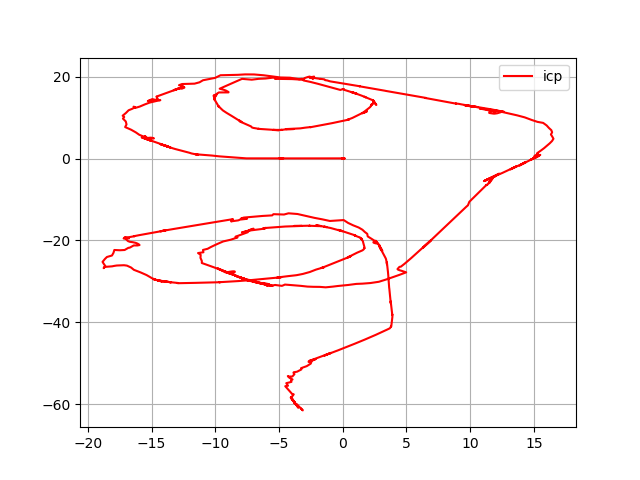

In [17]:
plt.figure()
plt.grid()
plt.plot(-df_icp['icp_y'].values, -df_icp['icp_x'].values, c='r', label='icp')
# plt.plot(df_gt['location_x'].values - np.ones(df_gt.shape[0])*df_gt['location_x'][0],
#          df_gt['location_y'].values - np.ones(df_gt.shape[0])*df_gt['location_y'][0], c='b', label='gt')
plt.legend()